# Dallas CDR

## Introduction

The spirit of data science includes exploration, traversing the unknown, and applying a deep understanding of the challenge you're facing. In an academic setting, it's hard to duplicate these tasks, but this lab will attempt to take a few steps away from the traditional, textbook, "plug the equation in" pattern, so you can get a taste of what analyzing data in the real world is all about.

After the September 11 attacks, a series of secret regulations, laws, and processes were enacted, perhaps to better protect the citizens of the United States. These processes continued through president Bush's term and were renewed and and strengthened during the Obama administration. Then, on May 24, 2006, the United States Foreign Intelligence Surveillance Court (FISC) made a fundamental shift in its approach to Section 215 of the Patriot Act, permitting the FBI to compel production of "business records" relevant to terrorism investigations, which are shared with the NSA. The court now defined as business recordsthe entirety of a telephone company's call database, also known as Call Detail Records (CDR or metadata).

News of this came to public light after an ex-NSA contractor leaked the information, and a few more questions were raised when it was further discovered that not just the call records of suspected terrorists were being collected in bulk... but perhaps the entirety of Americans as a whole. After all, if you know someone who knows someone who knows someone, your private records are relevant to a terrorism investigation. The white house quickly reassured the public in a press release that "Nobody is listening to your telephone calls," since, "that's not what this program is about." The public was greatly relieved.

The questions we'll be exploring in this lab assignment using K-Means are: exactly how useful istelephone metadata? It must have some use, otherwise the government wouldn't have invested however many millions they did into it secretly collecting it from phone carriers. Also what kind of intelligence can you extract from CDR metadata besides its face value?


## Part 1
We will be using a sample CDR dataset generated for 10 people living in the Dallas, Texas metroplex area. Our task will be to attempt to do what many researchers have already successfully done -partly de-anonymize the CDR data. People generally behave in predictable manners, moving from home to work with a few errands in between. With enough call data, given a few K-locations of interest, K-Means should be able to isolate rather easily the geolocations where a person spends the most of their time.

           In         Out Direction    CallDate         CallTime  DOW  \
0  4638472273  2666307251  Incoming  2010-12-25  07:16:24.736813  Sat   
1  4638472273  1755442610  Incoming  2010-12-25  21:18:30.053710  Sat   
2  4638472273  5481755331  Incoming  2010-12-25  14:52:42.878016  Sat   
3  4638472273  1755442610  Incoming  2010-12-25  16:02:09.001913  Sat   
4  4638472273  2145623768  Incoming  2010-12-25  15:28:35.028554  Sat   

         Duration                               TowerID   TowerLat   TowerLon  
0  0:02:41.741499  0db53dd3-eb9c-4344-abc5-c2d74ebc3eec  32.731611 -96.709417  
1  0:02:47.108750  aeaf8b43-8034-44fe-833d-31854a75acbf  32.731722 -96.709500  
2  0:04:35.356341  fadaa83f-6001-45fd-aa4a-17d6c6b7ec00  32.899944 -96.910389  
3  0:02:23.498499  fadaa83f-6001-45fd-aa4a-17d6c6b7ec00  32.899944 -96.910389  
4  0:03:54.692497  95d7920d-c3cd-4d20-a568-9a55800dc807  32.899944 -96.910389  
28
[[-96.70944573  32.73164942]
 [-96.694722    32.750556  ]]


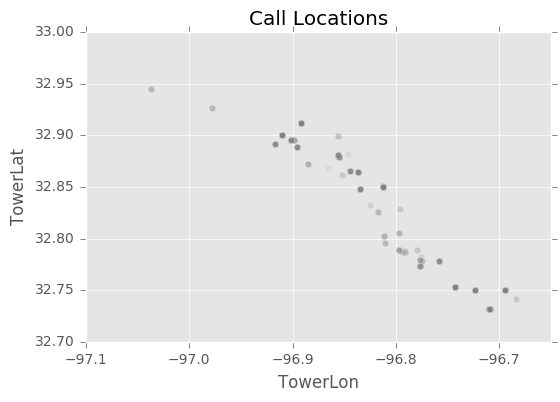

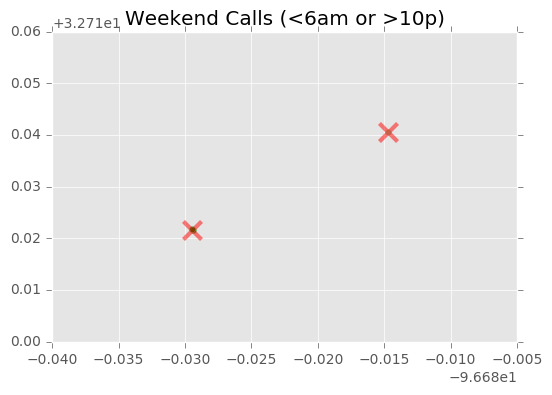

[[-96.694722    32.750556  ]
 [-96.70944573  32.73164942]]
[[-96.92355156  32.87096756]
 [-96.923556    32.871111  ]]
[[-96.865298    32.86592718]
 [-96.864444    32.857778  ]]
[[-96.83515822  32.84635163]
 [-96.852389    32.861222  ]]
[[-96.730278  32.875   ]
 [-96.759694  32.917333]]
[[-96.685556  32.770833]
 [-96.685556  32.770833]]
[[-96.840556  32.695   ]
 [-96.840667  32.705222]]
[[-96.604444  32.703056]
 [-96.604444  32.703056]]
[[-96.81277401  32.77401172]
 [-96.920139    32.702     ]]
[[-96.77946848  32.7722949 ]
 [-96.831472    33.01525   ]]


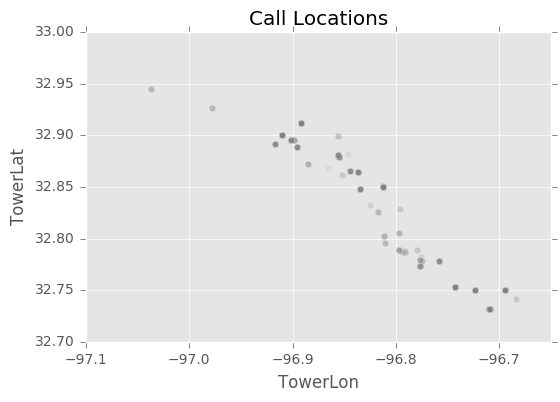

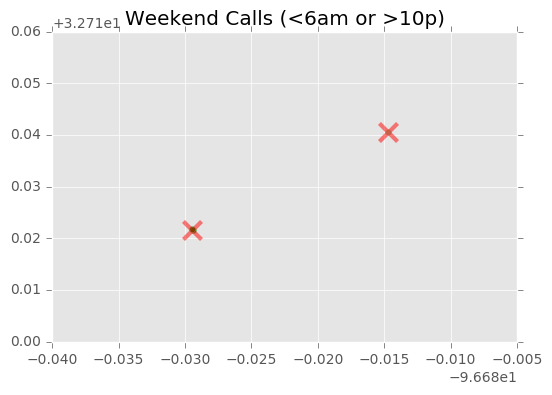

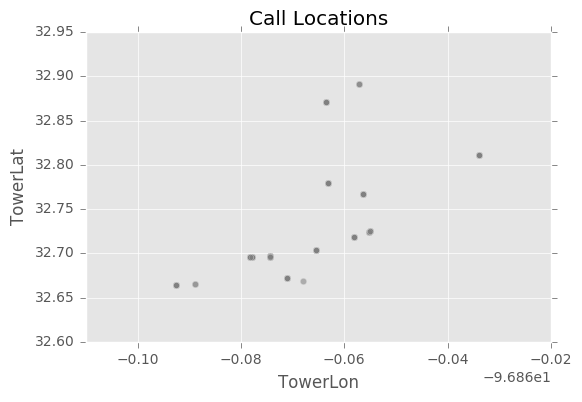

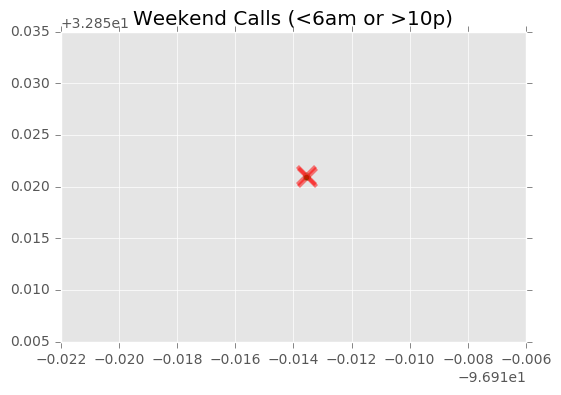

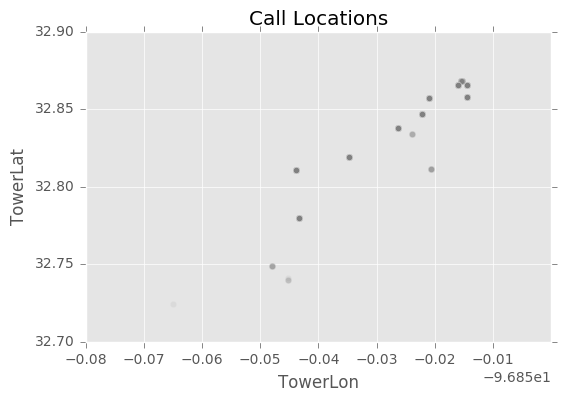

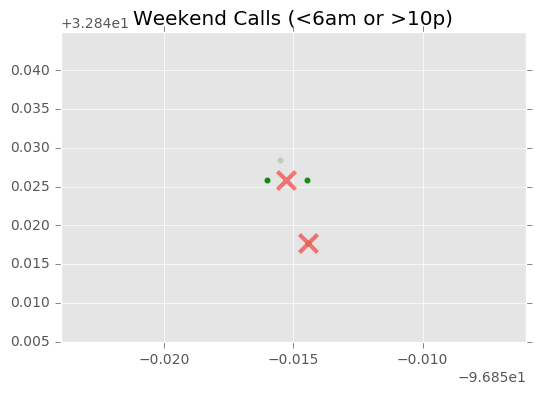

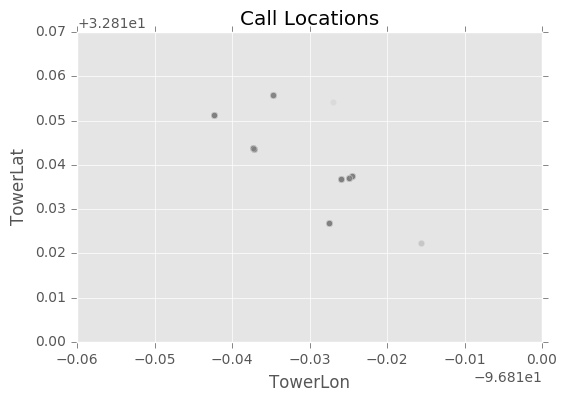

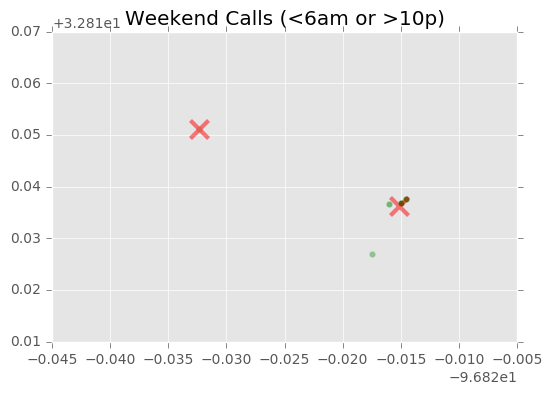

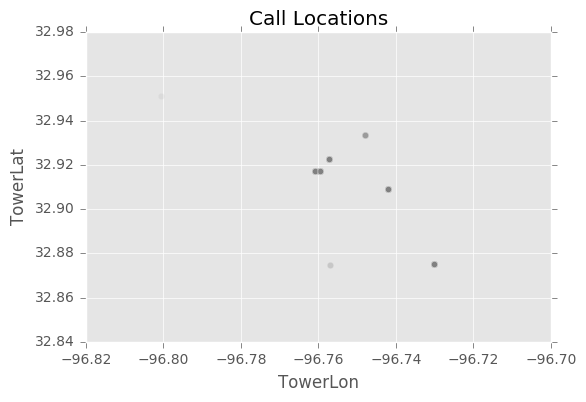

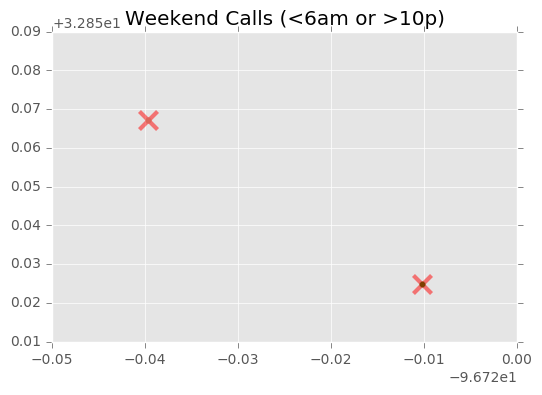

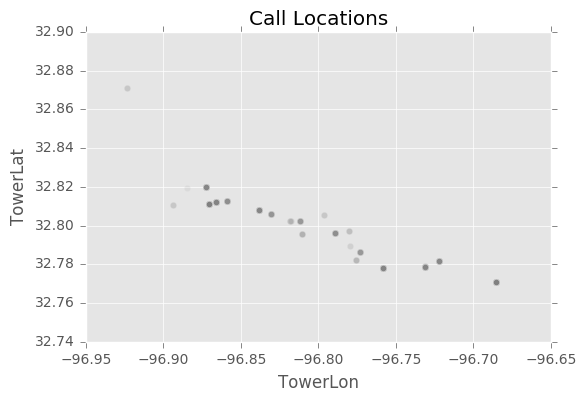

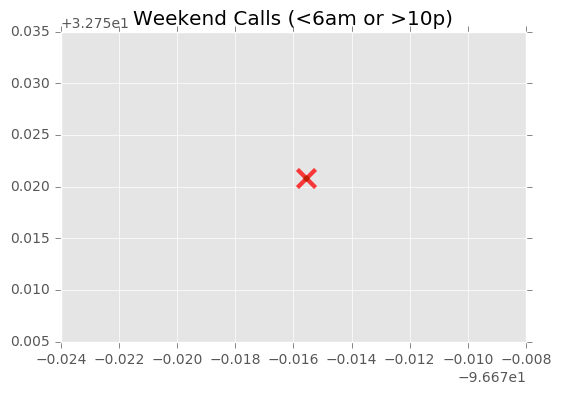

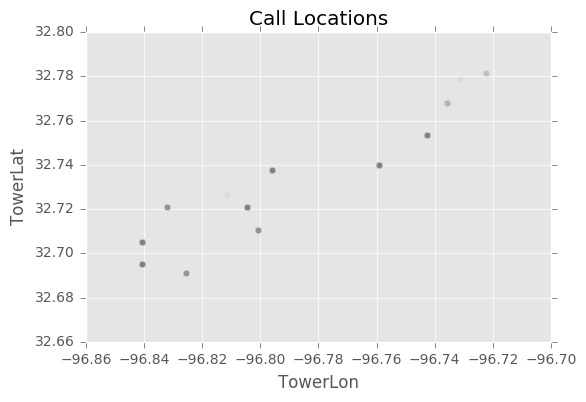

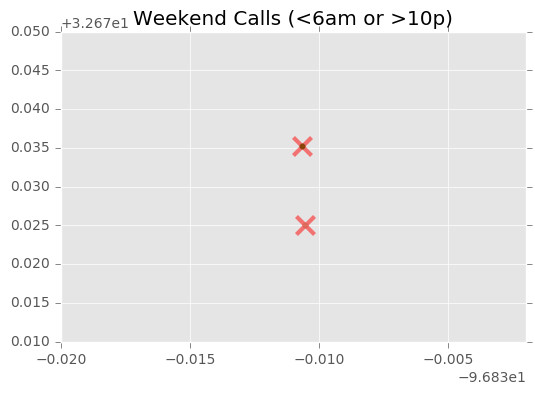

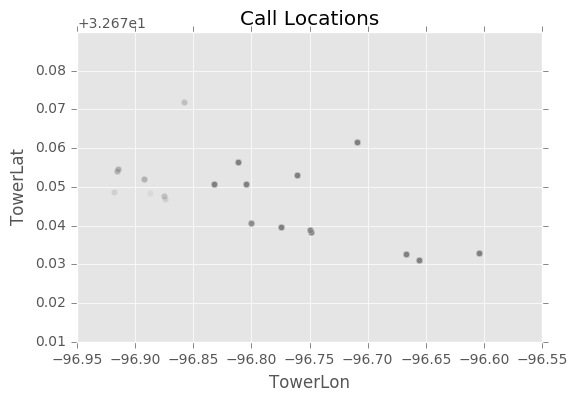

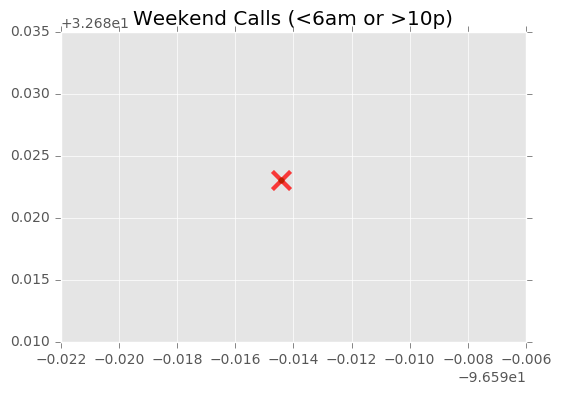

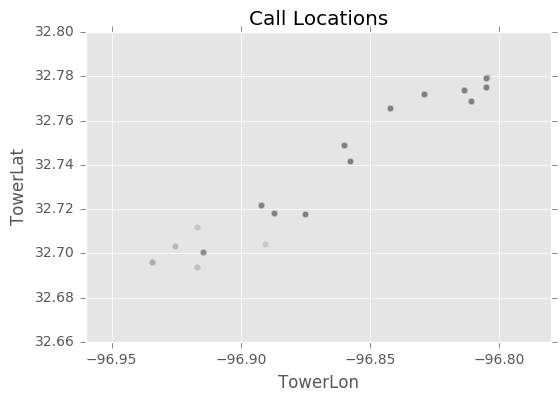

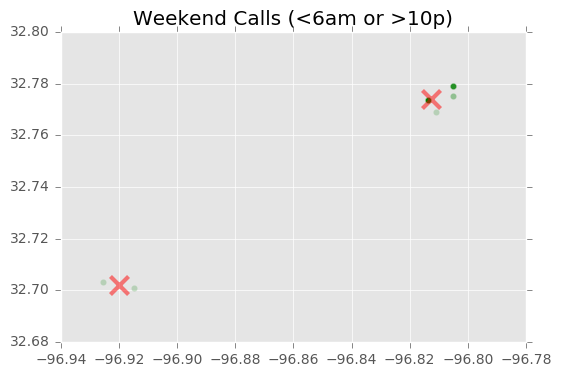

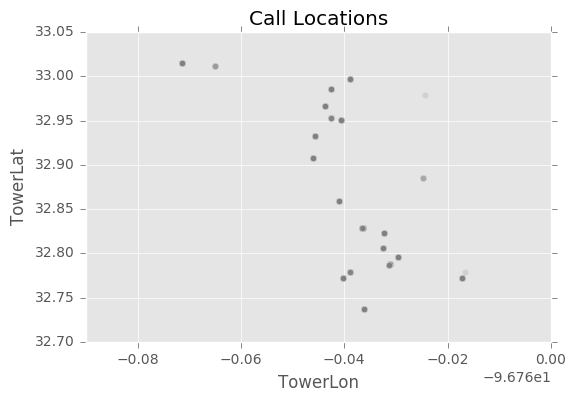

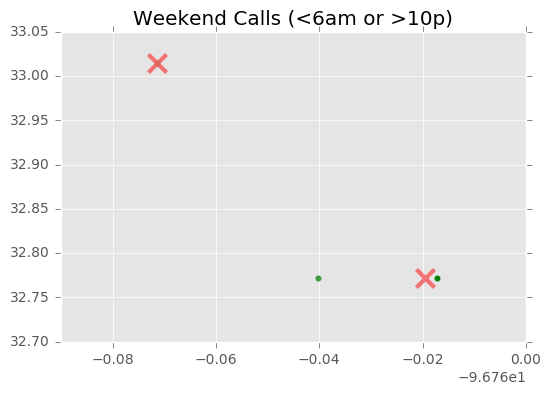

In [4]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

from sklearn.cluster import KMeans

matplotlib.style.use('ggplot') # Look Pretty

def showandtell(title=None):
  if title != None: plt.savefig(title + ".png", bbox_inches='tight', dpi=300)
  plt.show()
  #exit()

#
# This dataset has call records for 10 users tracked over the course of 3 years.
# Our job is to find out where the users likely live and work at!
#
# Load up the dataset and take a peek at its head
# Convert the date using pd.to_datetime, and the time using pd.to_timedelta
#
df = pd.read_csv('C:/Users/lcamp/Documents/edX/Microsoft_Data_Science/7_DAT210x/Module5/Datasets/CDR.csv')
print df.head()
df.CallDate = pd.to_datetime(df.CallDate)
df.CallTime = pd.to_timedelta(df.CallTime)
df.dtypes
#
# Get a distinct list of "In" phone numbers (users) and store the values in a
# regular python list.
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.tolist.html
#
users = df.In.unique().tolist()
# 
# Create a slice called user1 that filters to only include dataset records where the
# "In" feature (user phone number) is equal to the first number on your unique list above
#
user1 = df[df.In == users[0]]
# Plot all the call locations
user1.plot.scatter(x='TowerLon', y='TowerLat', c='gray', alpha=0.1, title='Call Locations')

#
# The locations map above should be too "busy" to really wrap your head around. This
# is where domain expertise comes into play. Our intuition tells us that people are likely
# to behave differently on weekends:
#
# On Weekends:
#   1. People probably don't go into work
#   2. They probably sleep in late on Saturday
#   3. They probably run a bunch of random errands, since they couldn't during the week
#   4. They should be home, at least during the very late hours, e.g. 1-4 AM
#
# On Weekdays:
#   1. People probably are at work during normal working hours
#   2. They probably are at home in the early morning and during the late night
#   3. They probably spend time commuting between work and home everyday
#
# Add more filters to the user1 slice you created. Add bitwise logic so that you're
# only examining records that came in on weekends (sat/sun).
#
user1.head()
user1 = user1[(user1.DOW=='Sat') | (user1.DOW=='Sun')]
#
# Further filter it down for calls that are came in either before 6AM OR after 10pm (22:00:00).
# We can use < and > to compare the string times, just make sure we code them as military time
# strings, eg: "06:00:00", "22:00:00": https://en.wikipedia.org/wiki/24-hour_clock
#
# We might also want to review the Data Manipulation section for this. Once we have our filtered
# slice, print out its length:
#
user1 = user1[(user1.CallTime<"06:00:00") | (user1.CallTime>"22:00:00")]
print user1.shape[0]
#
# Visualize the dataframe with a scatter plot as a sanity check. Since we're familiar
# with maps, we know well that our X-Coordinate should be Longitude, and our Y coordinate
# should be the tower Latitude. Check the dataset headers for proper column feature names.
# https://en.wikipedia.org/wiki/Geographic_coordinate_system#Geographic_latitude_and_longitude
#
# At this point, we don't yet know exactly where the user is located just based off the cell
# phone tower position data; but considering the below are for Calls that arrived in the twilight
# hours of weekends, it's likely that wherever they are bunched up is probably near where the
# caller's residence:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(user1.TowerLon,user1.TowerLat, c='g', marker='o', alpha=0.2)
ax.set_title('Weekend Calls (<6am or >10p)')

#
# Run K-Means with a K=1. There really should only be a single area of concentration. If we
# notice multiple areas that are "hot" (multiple areas the usr spends a lot of time at that are FAR
# apart from one another), then increase K=2, with the goal being that one of the centroids will
# sweep up the annoying outliers; and the other will zero in on the user's approximate home location.
# Or rather the location of the cell tower closest to their home.....
#
# We only feed in Lat and Lon coordinates to the KMeans algo, since none of the other
# data is suitable for our purposes. Since both Lat and Lon are (approximately) on the same scale,
# no feature scaling is required. Print out the centroid locations and add them onto our scatter
# plot. Use a distinguishable marker and color.
#
#
user1 = user1.loc[:,['TowerLon', 'TowerLat']]
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=2)
kmeans_model.fit(user1)
centroids = kmeans_model.cluster_centers_
ax.scatter(centroids[:,0], centroids[:,1], marker='x', c='red', alpha=0.5, linewidths=3, s=169)
print centroids

showandtell()
#
# Repeat the above steps for all 10 individuals, being sure to record their approximate home
# locations.
#
for user in users:
    userdf = df[df.In == user]
    userdf.plot.scatter(x='TowerLon', y='TowerLat', c='gray', alpha=0.1, title='Call Locations')
    userdf = userdf[(userdf.DOW=='Sat') | (userdf.DOW=='Sun')]
    userdf = userdf[(userdf.CallTime<"06:00:00") | (userdf.CallTime>"22:00:00")]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(userdf.TowerLon,userdf.TowerLat, c='g', marker='o', alpha=0.2)
    ax.set_title('Weekend Calls (<6am or >10p)')
    
    userdf = userdf.loc[:,['TowerLon', 'TowerLat']]
    kmeans_model = KMeans(n_clusters=2)
    kmeans_model.fit(userdf)
    centroids = kmeans_model.cluster_centers_
    ax.scatter(centroids[:,0], centroids[:,1], marker='x', c='red', alpha=0.5, linewidths=3, s=169)
    print centroids

plt.show()


Using Google Maps to find the location of apartment complexes in the Dallas, TX, USA area, we are able to conclude that the first user in the CDR, phone number: 04638472273, likely live at the *Spanish Grove Apartments*  complexes.


## Part 2

Now we will validate our results by comparing the user's weekday activity to their weekend activity

           In         Out Direction    CallDate         CallTime  DOW  \
0  4638472273  2666307251  Incoming  2010-12-25  07:16:24.736813  Sat   
1  4638472273  1755442610  Incoming  2010-12-25  21:18:30.053710  Sat   
2  4638472273  5481755331  Incoming  2010-12-25  14:52:42.878016  Sat   
3  4638472273  1755442610  Incoming  2010-12-25  16:02:09.001913  Sat   
4  4638472273  2145623768  Incoming  2010-12-25  15:28:35.028554  Sat   

         Duration                               TowerID   TowerLat   TowerLon  
0  0:02:41.741499  0db53dd3-eb9c-4344-abc5-c2d74ebc3eec  32.731611 -96.709417  
1  0:02:47.108750  aeaf8b43-8034-44fe-833d-31854a75acbf  32.731722 -96.709500  
2  0:04:35.356341  fadaa83f-6001-45fd-aa4a-17d6c6b7ec00  32.899944 -96.910389  
3  0:02:23.498499  fadaa83f-6001-45fd-aa4a-17d6c6b7ec00  32.899944 -96.910389  
4  0:03:54.692497  95d7920d-c3cd-4d20-a568-9a55800dc807  32.899944 -96.910389  


Examining person:  0
[[-96.85151976  32.87385429]
 [-96.70816184  32.73323174]


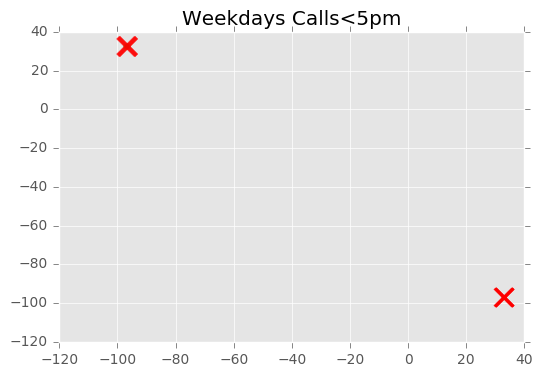

Cluster Analysis Inertia:  0.102797446515
------------------------------------------

  Cluster  0
    Centroid  [-96.85151976  32.87385429]
    #Samples  94

  Cluster  1
    Centroid  [-96.70816184  32.73323174]
    #Samples  306

  Cluster  2
    Centroid  [-96.90967196  32.9001744 ]
    #Samples  953

  Cluster  3
    Centroid  [-96.81945506  32.84577996]
    #Samples  52
[4638472273]


In [6]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib

from sklearn.cluster import KMeans

matplotlib.style.use('ggplot') # Look Pretty
#
# This dataset has call records for 10 users tracked over the course of 3 years.
# Our job is to find out where the users likely live at!

def showandtell(title=None):
  if title != None: plt.savefig(title + ".png", bbox_inches='tight', dpi=300)
  plt.show()
  #exit()

def clusterInfo(model):
  print "Cluster Analysis Inertia: ", model.inertia_
  print '------------------------------------------'
  for i in range(len(model.cluster_centers_)):
    print "\n  Cluster ", i
    print "    Centroid ", model.cluster_centers_[i]
    print "    #Samples ", (model.labels_==i).sum() # NumPy Power

# Find the cluster with the least # attached nodes
def clusterWithFewestSamples(model):
  # Ensure there's at least on cluster...
  minSamples = len(model.labels_)
  minCluster = 0
  for i in range(len(model.cluster_centers_)):
    if minSamples > (model.labels_==i).sum():
      minCluster = i
      minSamples = (model.labels_==i).sum()
  print "\n  Cluster With Fewest Samples: ", minCluster
  return (model.labels_==minCluster)

def doKMeans(data, clusters=0):
  #
  # We only feed in Lat and Lon coordinates to the KMeans algo, since none of the other
  # data is suitable for your purposes. Since both Lat and Lon are (approximately) on the same scale,
  # no feature scaling is required. Print out the centroid locations and add them onto your scatter
  # plot. Use a distinguishable marker and color.
  #
  # We fit ONLY the coordinates, and in the CORRECT order (lat first).
  #
  data = data.loc[:,['TowerLon', 'TowerLat']]
  model = KMeans(n_clusters=clusters)
  model.fit(data)
  centroids = model.cluster_centers_
  ax.scatter(centroids[:,0], centroids[:,1], marker='x', c='red', alpha=0.5, linewidths=3, s=169)
  print centroids
  return model

#
# Load up the dataset and take a peek at its head and dtypes.
# Convert the date using pd.to_datetime, and the time using pd.to_timedelta
#
df = pd.read_csv('C:/Users/lcamp/Documents/edX/Microsoft_Data_Science/7_DAT210x/Module5/Datasets/CDR.csv')
print df.head()
df.dtypes
df.CallDate = pd.to_datetime(df.CallDate)
df.CallTime = pd.to_timedelta(df.CallTime)

#
# Get a distinct list of "In" phone numbers (users) and store the values in a
# regular python list.
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.tolist.html
#
users = df.In.unique()

print "\n\nExamining person: ", 0
# 
# Create a slice called user1 that filters to only include dataset records where the
# "In" feature (user phone number) is equal to the first number on your unique list above
#
user1 = df[df.In == users[0]]
#
# Alter our slice so that it includes only Weekday (Mon-Fri) values.
#
user1 = user1[(user1.DOW=='Mon') | (user1.DOW=='Tue') | (user1.DOW=='Wed') | (user1.DOW=='Thr') | (user1.DOW=='Fri')]
#
# The idea is that the call was placed before 5pm. From Midnight-730a, the user is
# probably sleeping and won't call / wake up to take a call. There should be a brief time
# in the morning during their commute to work, then they'll spend the entire day at work.
# So the assumption is that most of the time is spent either at work, or in 2nd, at home.
#
user1 = user1[user1.CallTime<"17:00:00"]
#
# Plot the Cell Towers the user connected to
#
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(user1.TowerLon,user1.TowerLat, c='g', marker='o', alpha=0.2)
ax.set_title('Weekdays Calls<5pm')
#
# Run K-Means with K=3 or K=4. There really should only be a two areas of concentration. If we
# notice multiple areas that are "hot" (multiple areas the usr spends a lot of time at that are FAR
# apart from one another), then increase K=5, with the goal being that all centroids except two will
# sweep up the annoying outliers and not-home, not-work travel occasions. The other two will zero in
# on the user's approximate home location and work locations. Or rather the location of the cell
# tower closest to them.....
model = doKMeans(user1, 4)
#
# Print out the mean CallTime value for the samples belonging to the cluster with the LEAST
# samples attached to it. If our logic is correct, the cluster with the MOST samples will be work.
# The cluster with the 2nd most samples will be home. And the K=3 cluster with the least samples
# should be somewhere in between the two. What time, on average, is the user in between home and
# work, between the midnight and 5pm?
midWayClusterIndices = clusterWithFewestSamples(model)
midWaySamples = user1[midWayClusterIndices]
print "    Its Waypoint Time: ", midWaySamples.CallTime.mean()
#
# Let's visualize the results!
# First draw the X's for the clusters:
ax.scatter(model.cluster_centers_[:,1], model.cluster_centers_[:,0], s=169, c='r', marker='x', alpha=0.8, linewidths=2)
#
# Then save the results:
showandtell('Weekday Calls Centroids')

clusterInfo(model)
print user1.In.unique()

The users home location will likely be near the centroid with the second most attached samples.

Given the indexed time range, and the times people usually receive / make calls, the cluster with the most samples is likely to be the user's work location. For example, the phone number of the user who works at the US Post Office near Cockrell Hill Rd is likely to be *289-436-5987*.

Running our assignment with K=3 and looking at the code that gets the mean CallTime value for the cluster with the least amount of samples assigned to it (the cluster we suspect corresponds to the user transiting to work), the average CallTime value of that cluster is closest to 8 am.
